# Imports

In [1]:
import cv2
import numpy as np
import os
import mediapipe as mp
import threading
import imageio

from functools import partial
from matplotlib import pyplot as plt
import matplotlib.animation as animation

from sklearn.model_selection import train_test_split

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import TensorBoard

from scipy import stats
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score

from jproperties import Properties

gif_threads = {}

CAMERA_INDEX = 0

2023-10-13 21:39:55.792534: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Functions definitions

In [2]:
def mediapipe_detection(image, model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image.flags.writeable = False
    results = model.process(image)
    image.flags.writeable = True
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    return image, results

def draw_styled_landmarks(image, results):
    mp.solutions.drawing_utils.draw_landmarks(image, results.pose_landmarks, mp.solutions.holistic.POSE_CONNECTIONS,
                             mp.solutions.drawing_utils.DrawingSpec(color=(80,22,10), thickness=2, circle_radius=4), 
                             mp.solutions.drawing_utils.DrawingSpec(color=(80,44,121), thickness=2, circle_radius=2))

DESCRIPTOR_LEN = len(mp.solutions.holistic.PoseLandmark) * 4

def extract_descriptor(results):
    return np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(DESCRIPTOR_LEN)

def display_gif(gif_path, window_name, display_time_ms=100):
    gif = imageio.get_reader(gif_path)
    cv2.namedWindow(window_name, cv2.WINDOW_NORMAL)

    for i, gif_frame in enumerate(gif):
        cv2.imshow(window_name, gif_frame)
        cv2.waitKey(display_time_ms)  # Display time of each frame in milliseconds

    cv2.destroyWindow(window_name)

# Function to run display_gif in a thread
def display_gif_thread(gif_path, window_name):
    display_gif(gif_path, window_name)

def draw_frame(frame_index, landmarks_list):
    plt.clf()
    body_landmarks = landmarks_list[frame_index]

    x = [lm.x for lm in body_landmarks.landmark]
    y = [lm.y for lm in body_landmarks.landmark]

    plt.scatter(x, y, s=20, c='blue')

    connections = [(11, 12), (12, 24), (24, 23), (23, 11),
                   (11, 13), (13, 15), (15, 17),
                   (12, 14), (14, 16), (16, 18),
                   (11, 25), (25, 23),
                   (24, 26), (26, 28), (28, 30),
                   (23, 27), (27, 29), (29, 31)]

    for connection in connections:
        plt.plot([x[connection[0]], x[connection[1]]], [y[connection[0]], y[connection[1]]], c='blue')

    plt.axis('off')

    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.gca().invert_yaxis()

# Output directories

In [3]:

DATA_PATH = os.path.join('Dataset_atomic_gestures')
actions = np.array(['1', '2', '3'])
num_sequences = 10
sequence_length = 30

In [32]:
def prob_viz(res, actions, frame):
    colors = [(245, 117, 16), (117, 245, 16), (16, 117, 245)]
    output_frame = frame.copy()

    for idx, prob in enumerate(res):
        cv2.rectangle(output_frame, (0, 60 + idx * 40), (int(prob * 100), 90 + idx * 40), colors[idx], -1)
        cv2.putText(output_frame, actions[idx], (0, 85 + idx * 40), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)

        #print(actions[idx], prob)
        """if prob > 0.9:
            gif_path = os.path.join(DATA_PATH, actions[idx], f'{actions[idx]}.gif')
            if actions[idx] not in gif_threads or not gif_threads[actions[idx]].is_alive():
                thread = threading.Thread(target=display_gif_thread, args=(gif_path, actions[idx]))
                thread.start()
                gif_threads[actions[idx]] = thread"""

    return output_frame

In [5]:
# Clear dist 
for file in os.listdir(DATA_PATH):
    os.remove(os.path.join(DATA_PATH, file))

In [6]:
if not os.path.exists(DATA_PATH):
    os.mkdir(DATA_PATH)

for action in actions:
    if not os.path.exists(os.path.join(DATA_PATH, action)):
        os.mkdir(os.path.join(DATA_PATH, action))

for action in actions:
    for sequence in range(num_sequences):
        os.makedirs(os.path.join(DATA_PATH, action, str(sequence)))

In [7]:
def create_gif(landmarks_list, action):
    fig = plt.figure()
    ani = animation.FuncAnimation(fig, partial(draw_frame, landmarks_list=landmarks_list), frames=len(landmarks_list), interval=100)
    output_gif = os.path.join(DATA_PATH, action, f'{action}.gif')
    ani.save(output_gif, writer='imagemagick', fps=10)
    if os.path.exists(output_gif):
        return True
    else:
        return False

2023-10-13 21:40:53.738 Python[56249:2780678] WARNING: AVCaptureDeviceTypeExternal is deprecated for Continuity Cameras. Please use AVCaptureDeviceTypeContinuityCamera and add NSCameraUseContinuityCameraDeviceType to your Info.plist.
INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
2023-10-13 21:40:55.808 Python[56249:2780678] WARNING: Secure coding is not enabled for restorable state! Enable secure coding by implementing NSApplicationDelegate.applicationSupportsSecureRestorableState: and returning YES.


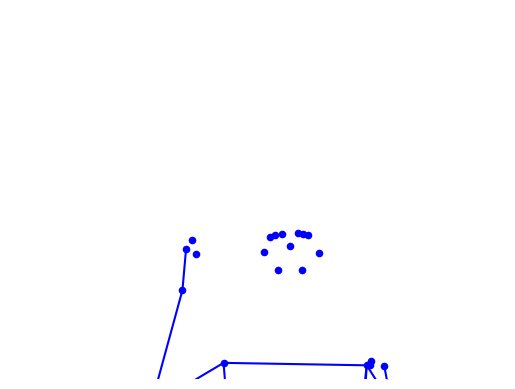

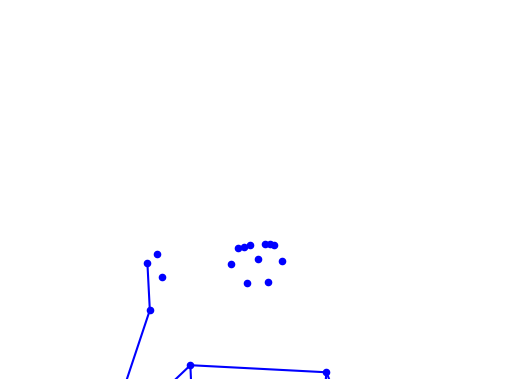

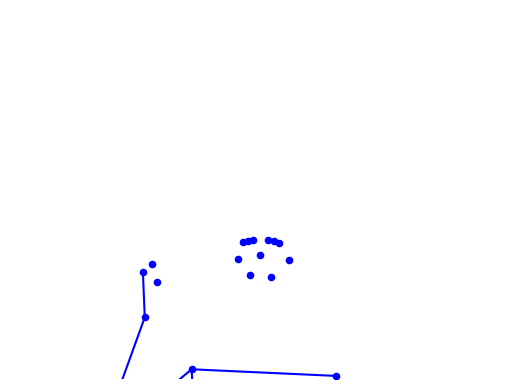

In [8]:
cap = cv2.VideoCapture(CAMERA_INDEX)

with mp.solutions.holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    for action in actions:
        gif_created = False
        landmarks_list = []
        single_gestures = {}
        recognized_combinations = []
        suggested_next_gestures = {}

        for sequence in range(num_sequences):
            for frame_num in range(sequence_length):
                ret, frame = cap.read()
                image, results = mediapipe_detection(frame, holistic)

                if not gif_created:
                    body_landmarks = results.pose_landmarks
                    if body_landmarks:
                        landmarks_list.append(body_landmarks)

                draw_styled_landmarks(image, results)

                if frame_num == 0:
                    cv2.putText(image, 'STARTING COLLECTION', (120, 200), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 4, cv2.LINE_AA)
                    cv2.putText(image, f'Action: {action}. Video #{sequence}', (15, 12), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
                    cv2.imshow('OpenCV Feed', image)
                    cv2.waitKey(2000)
                else:
                    cv2.putText(image, f'Action: {action}. Video #{sequence}', (15, 12), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
                    cv2.imshow('OpenCV Feed', image)

                npy_path = os.path.join(DATA_PATH, action, str(sequence), str(frame_num))
                keypoints = extract_descriptor(results)
                np.save(npy_path, keypoints)

                if cv2.waitKey(10) & 0xFF == ord('q'):
                    break

            if not gif_created and landmarks_list:
                gif_created = create_gif(landmarks_list, action)

    cap.release()
    cv2.destroyAllWindows()

## Build and Train LSTM Neural Network

In [9]:
label_map = {label: num for num, label in enumerate(actions)}
sequences, labels = [], []

for action in actions:
    for sequence in range(num_sequences):
        window = []
        for frame_num in range(sequence_length):
            res = np.load(os.path.join(DATA_PATH, action, str(sequence), f"{frame_num}.npy"))
            window.append(res)
        sequences.append(window)
        labels.append(label_map[action])

In [10]:
X = np.array(sequences)
y = to_categorical(labels).astype(int)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05)

In [11]:
model = Sequential()
model.add(LSTM(64, return_sequences=True, activation='relu', input_shape=(sequence_length, DESCRIPTOR_LEN)))
model.add(LSTM(128, return_sequences=True, activation='relu'))
model.add(LSTM(64, return_sequences=False, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(actions.shape[0], activation='softmax'))

In [12]:
log_dir = os.path.join('Logs')
tb_callback = TensorBoard(log_dir=log_dir)

model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])
model.fit(X_train, y_train, epochs=2000, callbacks=[tb_callback])



Epoch 1/2000
1/1 [==============================] - 4s 4s/step - loss: 1.0951 - categorical_accuracy: 0.4643
Epoch 2/2000
1/1 [==============================] - 0s 52ms/step - loss: 1.0871 - categorical_accuracy: 0.3571
Epoch 3/2000
1/1 [==============================] - 0s 47ms/step - loss: 1.0781 - categorical_accuracy: 0.4286
Epoch 4/2000
1/1 [==============================] - 0s 47ms/step - loss: 1.0767 - categorical_accuracy: 0.4286
Epoch 5/2000
1/1 [==============================] - 0s 36ms/step - loss: 1.0560 - categorical_accuracy: 0.3214
Epoch 6/2000
1/1 [==============================] - 0s 46ms/step - loss: 1.0908 - categorical_accuracy: 0.3571
Epoch 7/2000
1/1 [==============================] - 0s 72ms/step - loss: 1.0396 - categorical_accuracy: 0.4643
Epoch 8/2000
1/1 [==============================] - 0s 52ms/step - loss: 1.0464 - categorical_accuracy: 0.6786
Epoch 9/2000
1/1 [==============================] - 0s 56ms/step - loss: 1.0490 - categorical_accuracy: 0.5000
Epo

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 30, 64)            50432     
                                                                 
 lstm_1 (LSTM)               (None, 30, 128)           98816     
                                                                 
 lstm_2 (LSTM)               (None, 64)                49408     
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 3)                 99        
                                                                 
Total params: 204995 (800.76 KB)
Trainable params: 20499

# Evaluation using Confusion Matrix and Accuracy



In [14]:
yhat = model.predict(X_test)
ytrue = np.argmax(y_test, axis=1).tolist()
yhat = np.argmax(yhat, axis=1).tolist()


1/1 [==============================] - 0s 438ms/step


In [15]:
multilabel_confusion_matrix(ytrue, yhat)


array([[[1, 0],
        [1, 0]],

       [[1, 0],
        [0, 1]],

       [[1, 1],
        [0, 0]]])

In [16]:
accuracy_score(ytrue, yhat)

0.5

# Test in Real Time

In [39]:
sequence = []
sentence = ['','']
predictions = []

num_frames_for_stability = 10
threshold = 0.9

# Define known combinations and their corresponding suggested next gestures
known_combinations = {
    '123': ['1', '1', '3'],
    '212': ['2', '3', '2'],
    '312': ['3', '1', '2'],
    # Add more combinations and their suggested next gestures here
}

actual_combination = ""
idx = 0

# Initialize the suggested next gesture variable
suggested_next_gesture = ""

# Update the positions for displaying correct prediction and suggestion
left_text_position = (10, 60)
right_text_position = (480, 60)


cap = cv2.VideoCapture(CAMERA_INDEX)

with mp.solutions.holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():
        ret, frame = cap.read()
        image, results = mediapipe_detection(frame, holistic)

        draw_styled_landmarks(image, results)

        keypoints = extract_descriptor(results)
        sequence.append(keypoints)
        sequence = sequence[-sequence_length:]

        if len(sequence) == sequence_length:
            res = model.predict(np.expand_dims(sequence, axis=0))[0]
            predictions.append(np.argmax(res))
             
            is_stable_prediction = np.unique(predictions[-num_frames_for_stability:])[0]==np.argmax(res)
            if is_stable_prediction: 
                if res[np.argmax(res)] > threshold:            
                    if len(sentence) > 0: 
                        if actions[np.argmax(res)] != sentence[-1]:
                            sentence.append(actions[np.argmax(res)])
                    else:
                        sentence.append(actions[np.argmax(res)])

            if len(sentence) > 5: sentence = sentence[-5:]

            image = prob_viz(res, actions, image)

        # Display the correct prediction on the left
        if sentence:
            cv2.putText(image, f'Correct Prediction: {sentence[-1]}', left_text_position, cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2, cv2.LINE_AA)


        if actual_combination == "" and sentence != ['','']:
            for combination in known_combinations:
                if combination.startswith(''.join(sentence[-1])):
                    actual_combination = combination
                    idx = 1
                    suggested_next_gesture = known_combinations[combination][idx]
                    break
        else:
            if idx != 0 and idx < len(known_combinations[actual_combination]) and sentence[-1] == known_combinations[actual_combination][idx]:
                idx += 1
                suggested_next_gesture = known_combinations[actual_combination][idx]
                print('next', idx)
            elif idx != 0 and idx < len(known_combinations[actual_combination]) and sentence[-1] == sentence[-2]:
                suggested_next_gesture = known_combinations[actual_combination][idx]
                print('still', idx)
            else:
                print('null', idx)
                idx = 0
                actual_combination = ""
                suggested_next_gesture = ""
                

        if suggested_next_gesture != "":
            cv2.putText(image, f'Suggested Next Gesture: {suggested_next_gesture}', right_text_position, cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2, cv2.LINE_AA)


        cv2.imshow('OpenCV Feed', image)

        if cv2.waitKey(10) & 0xFF == ord('q'):
            break

    cap.release()
    cv2.destroyAllWindows()

null 0
null 0
null 0
null 0
null 0
null 0
null 0
null 0
null 0
null 0
null 0
null 0
null 0
null 0
null 0
null 0
null 0
null 0
null 0
null 0
null 0
null 0
null 0
null 0
null 0
null 0
null 0
null 0
null 0
1/1 [==============================] - 0s 34ms/step
null 0
1/1 [==============================] - 0s 26ms/step
null 0
1/1 [==============================] - 0s 25ms/step
null 0
1/1 [==============================] - 0s 26ms/step
null 0
1/1 [==============================] - 0s 27ms/step
null 0
1/1 [==============================] - 0s 27ms/step
null 0
1/1 [==============================] - 0s 27ms/step
null 0
1/1 [==============================] - 0s 27ms/step
null 0
1/1 [==============================] - 0s 25ms/step
null 0
1/1 [==============================] - 0s 28ms/step
null 0
1/1 [==============================] - 0s 24ms/step
null 0
1/1 [==============================] - 0s 26ms/step
null 0
1/1 [==============================] - 0s 26ms/step
null 0
1/1 [=========================

In [38]:
actual_combination


'123'